In [8]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:

def voss(nrows, ncols=16, meanwindow=2, rs=None):
    # code for this function adapted from code by Allen Downey (CC-BY license):
    # https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
    """
    Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    meanwindow: window size for rolling mean
    rs: random state
    
    returns: NumPy array
    """
    if rs is None:
        rs = np.random.RandomState()
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = rs.random_sample(ncols)
    array[:, 0] = rs.random_sample(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = rs.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = rs.randint(nrows, size=n)
    array[rows, cols] = rs.random_sample(n)
    
    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = pd.Series.rolling(df.sum(axis=1), meanwindow, min_periods=0).mean()
    # total = df.sum(axis=1)
    
    return total.values



In [10]:

c = np.sin(np.arange(0, np.pi, 0.066))

meanwindow=12


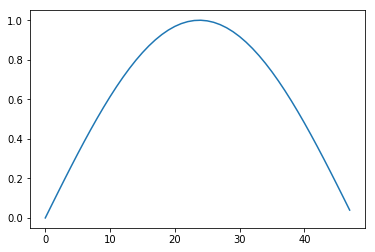

In [12]:
plt.plot(c)

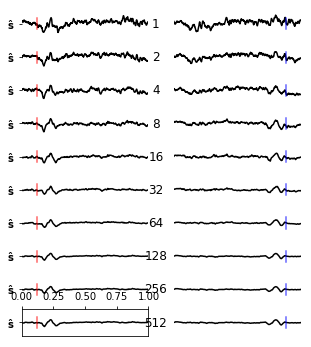

In [6]:
resp_buffer = 1500
baseline = 200
datasamples = 1500
min_rt = 300
max_rt = 1500
minlat = 60  # 25
maxlat = 100  # 75
stim_components = 3 
resp_components = 3
stim_samples = []
resp_samples = []
rts = []
n = 128
rs = np.random.RandomState(seed=999)
for i in range(n):
    eeg = voss(resp_buffer+datasamples+2*baseline+2*meanwindow,
               meanwindow=meanwindow, rs=rs)[meanwindow:-meanwindow]
    #eeg -= np.mean(eeg[:baseline])
    eeg -= np.mean(eeg)
    stim_onset = resp_buffer + baseline
    rt = rs.randint(min_rt, max_rt+1, 1)[0]
    rts.append(rt)
    resp_onset = resp_buffer + baseline + rt
    stim_latencies = rs.randint(minlat, maxlat+1, stim_components)
    resp_latencies = rs.randint(minlat, maxlat+1, resp_components)
    for i in range(len(stim_latencies)):
        if i%2 == 0:
            eeg[(stim_onset+np.sum(stim_latencies[:(i+1)])):
                (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] -= c
        else:
            eeg[(stim_onset+np.sum(stim_latencies[:(i+1)])):
                (stim_onset+np.sum(stim_latencies[:(i+1)])+len(c))] += c
    for i in range(len(stim_latencies)):
        if i%2 == 0:
            eeg[(resp_onset - np.sum(resp_latencies[:(i+1)])):
                (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] -= c
        else:
            eeg[(resp_onset - np.sum(resp_latencies[:(i+1)])):
                (resp_onset - np.sum(resp_latencies[:(i+1)])+len(c))] += c  
    # stim_samples.append(eeg.copy())
    stim_samples.append(eeg[(stim_onset-baseline):(stim_onset+datasamples)])
    #resp_samples.append(eeg[(datasamples+baseline-rt):(2*baseline+rt)])
    # print rt, baseline+rt-datasamples, 2*baseline+rt
    resp_samples.append(eeg[(resp_onset-datasamples):(resp_onset+baseline)])

ymax = 3
fig, axs = plt.subplots(10, 2, sharex=False, sharey=False, figsize=(5, 6))
for i, n in enumerate([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]):
    axs[i, 0].plot(np.mean(stim_samples[:n+1], 0), 'k-')
    axs[i, 0].plot([baseline, baseline], [-ymax*0.4, ymax*0.4], 'r-', alpha=0.6)
    axs[i, 0].set_xticks([])
    # axs[i, 0].set_xticks(np.arange(baseline, np.shape(stim_samples)[1]+1, 500))
    # axs[i, 0].set_xticklabels([])
    # axs[0].set_ylabel('Voltage')
    # axs[i, 0].set_ylabel(r'$\mathrm{\mu}V$')
    #axs[i, 0].set_ylabel(r'$\mathbf{\hat{s}_i}$')
    # axs[i, 0].text(
    #     0.06, 0.75, r'$\mathbf{\hat{s}_i}$', horizontalalignment='center',
    #     verticalalignment='center', transform=axs[i, 0].transAxes,
    #     size='large')
    axs[i, 1].plot(np.mean(resp_samples[:n+1], 0), 'k-')
    axs[i, 1].plot([datasamples, datasamples], [-ymax*0.4, ymax*0.4],
                   'b-', alpha=0.6)
    # axs[i, 1].set_xticks(np.arange(0, np.shape(stim_samples)[1]+1, 500))
    axs[i, 1].set_xticks([])
    axs[i, 1].set_xticklabels([])
    axs[i, 0].set_ylim((-ymax, ymax))
    axs[i, 1].set_ylim((-ymax, ymax))
    axs[i, 0].set_yticks([0])
    # axs[i, 1].set_yticks([0])
    axs[i, 1].set_yticks([])
    # axs[i, 0].set_yticklabels([r'$\mathbf{\hat{s}}('+str(n)+')$'])
    axs[i, 0].set_yticklabels([r'$\mathbf{\hat{s}}$'])
    # axs[i, 0].set_yticklabels([r'$\frac{1}{'+str(n)+r'}\sum_{i=0}^{'+str(n)+r'}x_i$'])
    # axs[i, 1].set_yticklabels([])
    # axs[i, 1].text(
    #     0.06, 0.75, r'$\mathbf{\hat{s}_i}$', horizontalalignment='center',
    #     verticalalignment='center', transform=axs[i, 1].transAxes,
    #    size='large')
    axs[i, 1].set_ylabel(n, rotation=0, size='large',
                         verticalalignment='center', labelpad=18)
    # axs[i, 1].text(1.12, 0.5, n, horizontalalignment='center',
    #               verticalalignment='center',
    #               transform=axs[i, 1].transAxes, size='large')
    axs[i, 0].set_frame_on(False)
    axs[i, 1].set_frame_on(False)
    axs[i, 0].set_xlim((0, datasamples+baseline))
    axs[i, 1].set_xlim((0, datasamples+baseline))
#axs[i, 0].set_xlabel('Time (ms) relative to stimulus')
#axs[i, 1].set_xlabel('Time (ms) relative to response')
axs[i, 0].set_xticklabels(np.arange(
    baseline, np.shape(stim_samples)[1]+1, 500)-baseline)
axs[i, 1].set_xticklabels(np.arange(
    -np.shape(stim_samples)[1]+baseline, 1, 500))
# fig.savefig('../figs/erp/sim_erp.pdf')
# axs[0, 1].text(1.12, 0.9, 'n', horizontalalignment='center',
#                verticalalignment='center',
#                transform=axs[0, 1].transAxes, size='xx-large')
# axs[i, 1].text(1.12, -0.25, 'n', horizontalalignment='center',
#                verticalalignment='center',
#                transform=axs[i, 1].transAxes, size='large')
ax_stim = axs[i, 0].twiny()
ax_stim.set_frame_on(True)
ax_stim.patch.set_visible(False)


In [7]:
for sp in ax_stim.spines: #.itervalues():
    sp.set_visible(False)
ax_stim.spines["bottom"].set_visible(True)
ax_stim.xaxis.set_ticks_position("bottom")
ax_stim.xaxis.set_label_position("bottom")
ax_stim.set_xlabel('Time relative to stimulus')
ax_stim.set_xticks(np.arange(baseline, np.shape(stim_samples)[1]+1, 500))
ax_stim.set_xticklabels(
    np.arange(baseline, np.shape(stim_samples)[1]+1, 500)-baseline)
ax_stim.spines["bottom"].set_position(("axes", 0.25))
ax_stim.set_xlim((0, datasamples+baseline))



AttributeError: 'str' object has no attribute 'set_visible'

In [ ]:
ax_resp = axs[i, 1].twiny()
ax_resp.set_frame_on(True)
ax_resp.patch.set_visible(False)
for sp in ax_resp.spines: .itervalues():
    sp.set_visible(False)
ax_resp.spines["bottom"].set_visible(True)
ax_resp.xaxis.set_ticks_position("bottom")
ax_resp.xaxis.set_label_position("bottom")
ax_resp.set_xlabel('Time relative to response')
ax_resp.set_xticks(np.arange(0, np.shape(stim_samples)[1]+1, 500))
ax_resp.set_xticklabels(np.arange(-np.shape(stim_samples)[1]+baseline, 1, 500))
ax_resp.spines["bottom"].set_position(("axes", 0.25))
ax_resp.set_xlim((0, datasamples+baseline))
fig.subplots_adjust(0.05, 0.03, 0.98, 1.02, 0.25, -0.5)
#fig.savefig('../../figs/erp/sim_erp_1to512.pdf')

